In [1]:
using Convex
using SCS
using PyPlot
using Distributions

srand(123);

In [2]:
function cloud!(x, res, start, n, d)
    dim = size(x, 2)
    for i=1:n
        res[start+i, 1] = x[1] + rand(d)
        res[start+i, 2] = x[2] + rand(d)
    end
end

function circle!(x, r, res, start, n, d)
    dim = size(x, 2)
    for i=1:n
        angle = rand() * 2 * pi
        res[start+i, 1] = x[1] + cos(angle) * r + rand(d)
        res[start+i, 2] = x[2] + sin(angle) * r + rand(d)
    end    
end

circle! (generic function with 1 method)

In [3]:
function lin_sep_two_clouds()
    x = zeros(100, 2)
    cloud!([0 0], x,  0, 50, Normal(0, 0.2))
    cloud!([1 1], x, 50, 50, Normal(0, 0.2))

    y = repeat([1; -1], inner=50)
    x, y    
end
    
function two_cocentric()
    x = zeros(100, 2)
    cloud!( [0 0],      x,  0, 50, Normal(0, 0.1))
    circle!([0 0], 1.5, x, 50, 50, Normal(0, 0.1))

    y = repeat([1; -1], inner=50)
    x, y
end

function three_cocentric()
    x = zeros(210, 2)
    cloud!( [0 0],      x,   0, 70, Normal(0, 0.2))
    circle!([0 0], 1.5, x,  70, 70, Normal(0, 0.2))
    circle!([0 0], 3, x,   140, 70, Normal(0, 0.2))

    y = repeat([1; -1; 1], inner=70)
    x, y
end

three_cocentric (generic function with 1 method)

In [4]:
type SVM
    α::SparseVector{Number, Int64}
    support_vectors_data::Array{Number, 2}
    support_vectors_labels::Array{Number, 1}
    b::Number
    K::Function
end

In [5]:
function make_grammian(K, x, y)
    N = size(x, 1)
    Q = zeros(N, N)
    
    for i=1:N
        for j=1:i
            Q[i, j] = K(x[i, :], x[j, :]) * y[i] * y[j]
            Q[j, i] = Q[i, j]
        end
    end
    
    min_ev = eigmin(Q)
    if min_ev < 0
        Q - 2*min_ev .* I
    else
        Q
    end
end

function train_svm(data, labels; K=vecdot, tol=eps()) :: SVM
    N = size(data, 1)
    
    Q = make_grammian(K, data, labels)
    
    # compute α
    α = Variable(N, 1)
    
    problem = minimize(0.5*quadform(α, Q) - vecdot(α, ones(N)))
    problem.constraints += α >= 0
    problem.constraints += vecdot(α, y) == 0

    solve!(problem, SCSSolver(verbose=false))
    α = α.value[:, 1]
    α[α .<= tol] = 0
    α = sparse(α)
    
    # compute w
    w = zeros(size(data, 2))
    for i = 1:N
        if α[i] > 0
            w += α[i] * y[i] * x[i, :]
        end
    end
    
    # compute b
    b = 0
    for i = 1:N
        if α[i] > 0
            b = y[i] - K(x[i, :], w)
            break
        end
    end
    
    SVM(α, x[α .!= 0, :], y[α .!= 0], b, K)
end

train_svm (generic function with 1 method)

In [11]:
function svm_predict(svm :: SVM, x)
    f = svm.b
    j = 1
    for i = 1:length(svm.α)
        if svm.α[i] > 0
            f += svm.support_vectors_labels[j] * svm.α[i] * svm.K(x, svm.support_vectors_data[j, :])
            j += 1
        end
    end
    
    f
end

function svm_show_contour(svm :: SVM, xrange, yrange)
    N = length(xrange)
    
    f(x) = svm_predict(svm, x)
    
    xgrid = repmat(xrange', N, 1 )
    ygrid = repmat(yrange, 1, N)
    
    z = zeros(N,N)

    for i in 1:N
        for j in 1:N
            z[i:i,j:j] = f([xrange[i], yrange[j]])
        end
    end
    
    zgrid = reshape(z, N, N)

    cs = contour(xgrid, ygrid, zgrid, colors="black", levels=[0])
    clabel(cs, inline=1, fontsize=10);
end


svm_show_contour (generic function with 1 method)

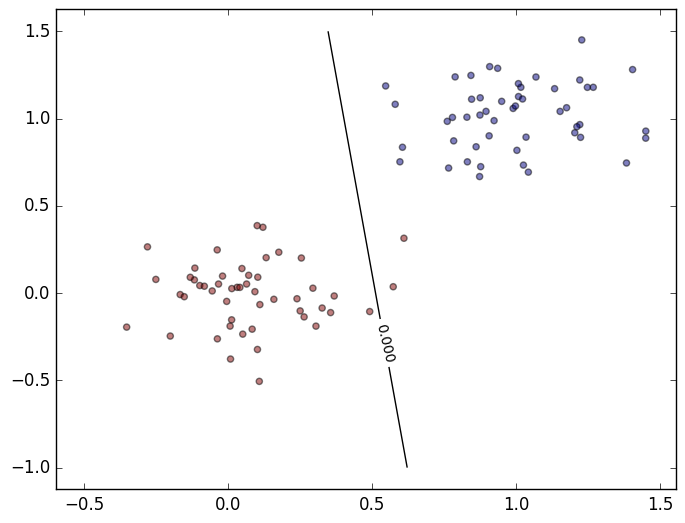

In [12]:
x, y = lin_sep_two_clouds()
svm₀ = train_svm(x, y, tol=10.0e-6)
svm_show_contour(svm₀, linspace(-0.5, 1.0, 50), linspace(-1.0, 1.5, 50))
scatter(x[:, 1], x[:, 2], c=y, alpha=0.5);

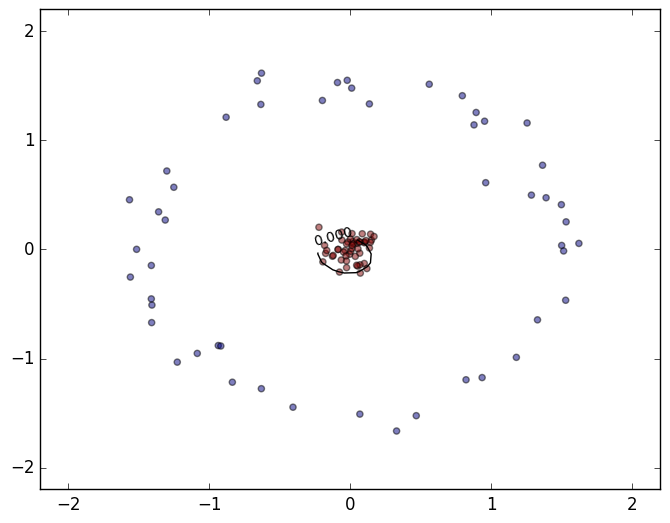

In [14]:
x, y = two_cocentric()
poly(x₁, x₂) = (1 + vecdot(x₁, x₂))^2
svm₂ = train_svm(x, y, tol=10.0e-6, K=poly)
svm_show_contour(svm₂, linspace(-2.0, 2.0, 50), linspace(-2.0, 2.0, 50))
scatter(x[:, 1], x[:, 2], c=y, alpha=0.5);

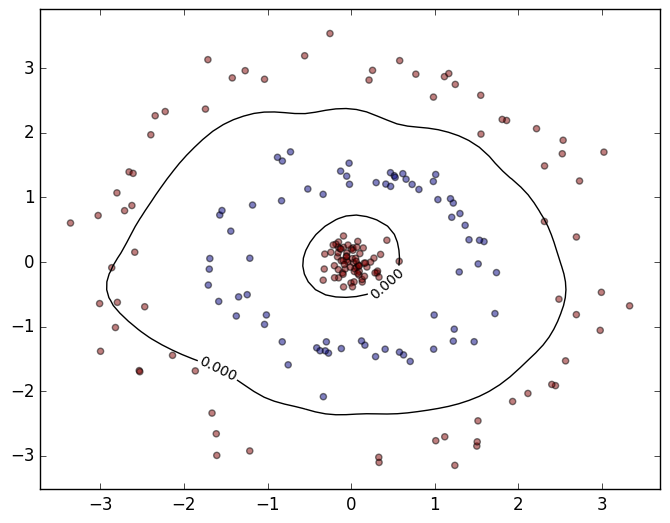

In [13]:
x, y = three_cocentric()
rbf(x₁, x₂) = exp(-norm(x₁ - x₂))
svm₁ = train_svm(x, y, tol=10.0e-6, K=rbf)
svm_show_contour(svm₁, linspace(-3.0, 3.0, 50), linspace(-3.0, 3.0, 50))
scatter(x[:, 1], x[:, 2], c=y, alpha=0.5);